# **Global Peatland Assessment**
<span style = "font-size: 1.5em;"> ***PEATMAP: Global Peatland Distribution*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The assessment will estimate the spatial distribution of peat area in the region of interest. Moreover, the level of degradation will be assessed by using Hansen Forest Change and Tropical Humid Forest by assuming peat degradation will occurr in the non-forested peat

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile
> - **peat_directory** : select the global peatland shapefile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")
> - **forest_threshold** : minimum percentage of Hanssen tree cover to defined foret area (example: 30)
> - **min_forest_map_area** : specify the minimum mapping area (pixel units) to specify the minimum area to defined as forest (example: 0.5 Ha = 6 pixels; 1 Ha = 11 pixels; 2 Ha = 22 pixels)
> - **min_forestloss_map_area** : specify the minimum mapping area (pixel units) to specify the minimum area to defined as forest loss (example: 0.5 Ha = 6 pixels; 1 Ha = 11 pixels; 2 Ha = 22 pixels)
> - **tileScale** : In case any error/issue of computation memory while running the calculation in very large or small area (example: 4). [See this for further explanation](https://gis.stackexchange.com/questions/373250/understanding-tilescale-in-earth-engine)

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Raster Datasets
> - Primary forest and Non-primary forest in 2001 and 2022
> - Primary and non-primary forest loss in 2002-2021

- csv, graph and maps 
> - Peat Extent Area (Ha)
> - Degraded peat in 2001 and 2022 Area (Ha)

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

The data shows the distribution of global peatland area (Ha) which was derived from the compilation of most detailed and up-to-date available datasets at global, regional and local from multiple sources. The datasets was selected based on **relevancies** (the ability to **identify and distinguish peatland from other land cover**); **Spatial Resoltuion** (the finest and **detail resolution**); **Age** (the most **latest version** datasets available)

<img src="https://i.ibb.co/jys817N/PEATMAP-data-sources-list.png" alt="PEATMAP-data-sources-list" border="0"></a>

<span style="font-size:1.1em;"> ***Source*** </span>
1. PEATMAP
Xu, Jiren and Morris, Paul J. and Liu, Junguo and Holden, Joseph (2017) PEATMAP: Refining estimates of global peatland distribution based on a meta-analysis. University of Leeds. [Dataset] https://doi.org/10.5518/252
2. Hansen Tree Cover and Forest Loss
Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. "High-Resolution Global Maps of 21st-Century Forest Cover Change." Science 342 (15 November): 850-53. 10.1126/science.1244693 Data available on-line at: https://glad.earthengine.app/view/global-forest-change.
3. Primary Humid Tropical Forest
Turubanova S., Potapov P., Tyukavina, A., and Hansen M. (2018) Ongoing primary forest loss in Brazil, Democratic Republic of the Congo, and Indonesia. Environmental Research Letters. https://doi.org/10.1088/1748-9326/aacd1c

### <span style = "font-size: 1em;"> ***Note*** </span>

1. The script will only estimate the **peat extent area** since peat depth information is unavailable in PEATMAP dataset
2. Hansen Forest Change will be applied in the **Peat and Non-peat Area**
3. To estimate peat degradation, raster calculation will be applied on the Hansen Raster datassets. Geemap package only allow to export the data to google drive, hence,  before proceed with the **Peat Degradation Assessment Sections**, make sure **the datasets has been downloaded from google drive to the local storage**

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib import colors
from matplotlib.patches import Patch
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from geemap import cartoee
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt

In [2]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
peat_directory = filedialog.askopenfile(title = "Open Peatland Shapefile")
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_PeatAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [5]:
#Import the required Libraries to open pop-up input data
from tkinter import *

# specify project name
projectname = simpledialog.askstring("Input", "Specify project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  RVL_IDN_PSM_01_CK
All data will be reprojected to  EPSG:32749  canopy cover
Column name is  Name


## Spatial Distribution of Peat Extent

### Peat and Non-peat Area Estimation

In [6]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
peat = gpd.read_file(peat_directory.name)

# reproject to UTM
roi_proj  = roi.to_crs(crs = projection)
peat_proj = peat.to_crs(crs = projection)

In [7]:
# clip peatland by roi then union with roi to create peat and non-peat
# peat : 1
# non-peat: 2
peat_roi_proj = gpd.clip(peat_proj, roi_proj)
peat_roi_proj["Data"] = 1
peat_roi_proj["Data_cat"] = "Peat"
peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=True)

C:\Users\KurniaLatifiana\anaconda3\envs\geemap2\lib\site-packages\geopandas\tools\clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [ ]:
# incase topological error is encounterd in the union process

#try:
#    peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=False)
#except (TopologicalError, TopologyException):
#    #skipping error here
#    pass

In [8]:
# calculate peat and non-peat area
peat_nonpeat_roi_proj["Area_Ha"] = peat_nonpeat_roi_proj['geometry'].area/10000
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.fillna(2)
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.astype('int64')
peat_nonpeat_roi_proj.Data_cat = peat_nonpeat_roi_proj.Data_cat.fillna("Non-peat")

# create new ID
peat_nonpeat_roi_proj['new_id'] = np.arange(len(peat_nonpeat_roi_proj))

### Processing Check

In [9]:
if 'Peat' in peat_nonpeat_roi_proj['Data_cat'].unique():
    messagebox.showinfo("Information", "Peat is found, proceed the assessment")
else:
    messagebox.showerror("Information", "Peat is not found, Peatland Assessment is Finished")

### Data Visualization

In [10]:
peat_roi_proj_4326 = peat_roi_proj.to_crs(crs = 'EPSG:4326')
roi_proj_4326 = roi_proj.to_crs(crs = 'EPSG:4326')
peat_nonpeat_roi_proj_4326 = peat_nonpeat_roi_proj.to_crs(crs = 'EPSG:4326')

colors_peat = ['#efb403', '#674d01']
colormap = LinearSegmentedColormap.from_list('PeatMap',colors_peat)
scheme_pnp = mc.UserDefined(peat_nonpeat_roi_proj_4326['Data'], bins = [1,2])

In [11]:
# visualization parameters
roi_kwargs = {'linewidth': 0.5, 'edgecolor': 'white'}
peat_kwargs = {'linewidth' : 0.5, 'edgecolor': None, 'facecolor': '#efb403'}

<Figure size 3000x3000 with 0 Axes>

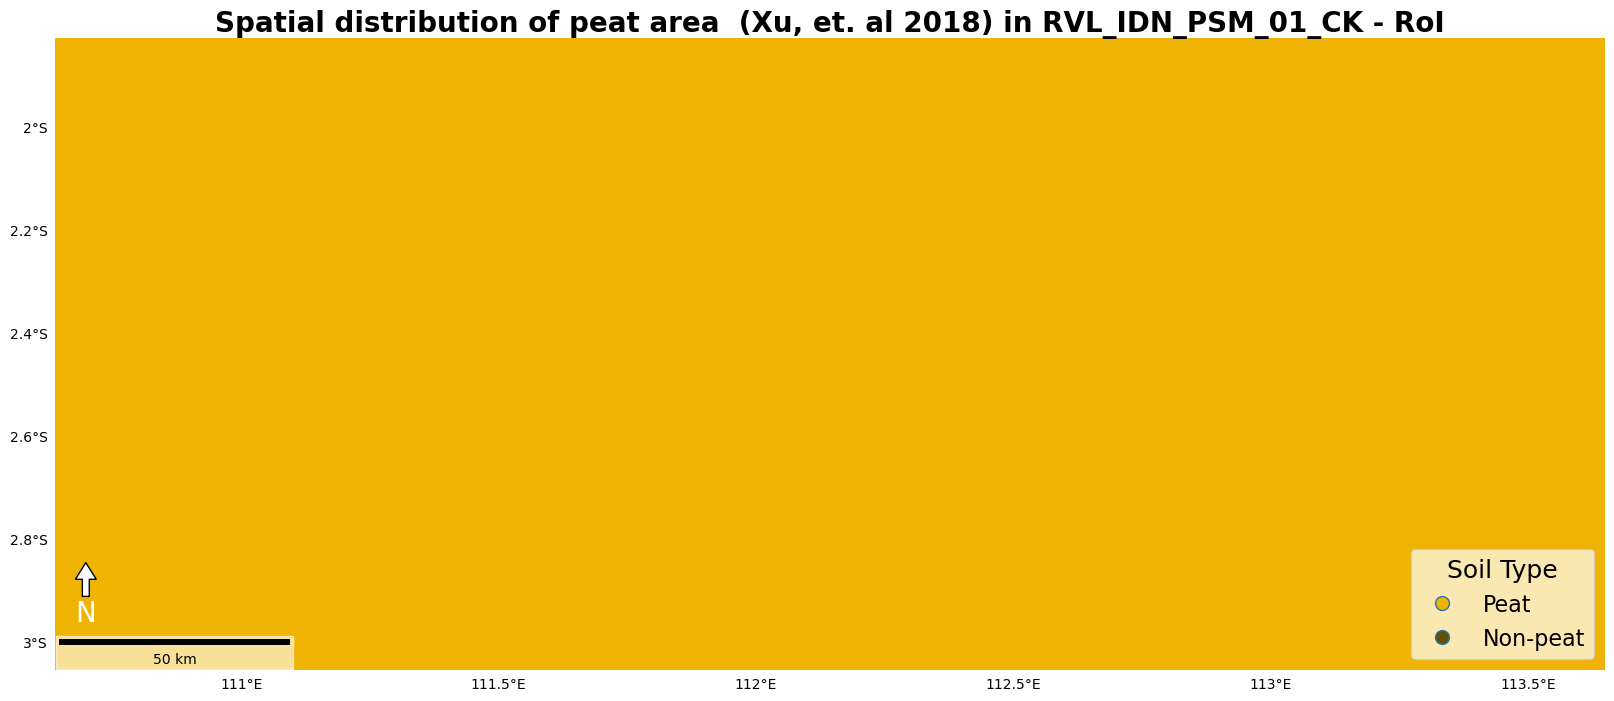

In [12]:
# Peat Map
fig_peat = plt.figure(figsize=(30,30), facecolor = 'white', frameon=True)
ax_peat = gplt.webmap(df=roi_proj_4326, projection=gcrs.WebMercator(),
                      provider=ctx.providers.Esri.WorldImagery, figsize=(20,20))
ax_peat = gplt.polyplot(roi_proj_4326, projection = gcrs.WebMercator(), **roi_kwargs, ax = ax_peat)
#ax_peat = gplt.polyplot(peat_roi_proj_4326, projection = gcrs.WebMercator(), **peat_kwargs, ax = ax_peat)

#ax_peat = gplt.polyplot(peat_nonpeat_roi_proj_4326, projection = gcrs.WebMercator(), ax = ax_peat)
ax_peat = gplt.choropleth(peat_nonpeat_roi_proj_4326, hue='Data', projection=gcrs.WebMercator(),    
                          edgecolor = None, linewidth = 0.5, cmap=colormap,
                          legend=True, ax = ax_peat,
                          legend_kwargs={'frameon': True, 'framealpha' : 0.7, 'loc': 'lower right', 'fontsize' : 16,
                                         'title':'Soil Type', 'title_fontsize' : 18},
                          legend_labels=['Peat', 'Non-peat'],
                          scheme = scheme_pnp
)

# add north arrow
x, y, arrow_length = 0.02, 0.17, 0.08
ax_peat.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=5, headwidth=15),
                 ha='center', va='center', fontsize=20,
                 xycoords=ax_peat.transAxes)

# add scale bar
ax_peat.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_peat = ax_peat.gridlines(visible = None, draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax_peat.top_labels=False
ax_peat.right_labels = False

# add title
plt.title("Spatial distribution of peat area  (Xu, et. al 2018) in " +  projectname + " - RoI", va = 'center_baseline', fontsize=20, fontweight="bold")

# save map
plt.savefig(os.path.join(out_dir, projectname + '_PeatDistribution_Map.png'), bbox_inches='tight', 
            facecolor=fig_peat.get_facecolor())




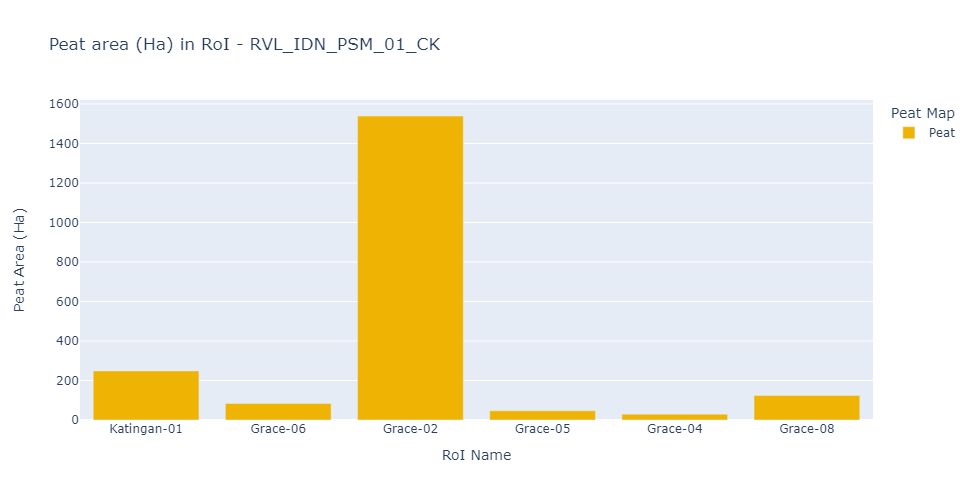

In [13]:
# Peat area in RoI
peat_nonpeat_roi_proj_filtered = peat_nonpeat_roi_proj.loc[peat_nonpeat_roi_proj['Data'] == 1]
fig_peatarea = px.bar(peat_nonpeat_roi_proj_filtered, x = peat_nonpeat_roi_proj_filtered[roi_column_name],
                      y =peat_nonpeat_roi_proj_filtered.Area_Ha, color = 'Data_cat',
                      category_orders={"Peat Map": ["Peat"]},
                      color_discrete_sequence = ['#efb403'],
                      width=1400, height=500, 
                      labels = {roi_column_name: "RoI Name","Area_Ha": "Peat Area (Ha)"},
                      title ="Peat area (Ha) in RoI - " + projectname)
fig_peatarea.update_layout(legend_title_text='Peat Map')

### Export Data

In [14]:
# 1. Peatland Area csv
peat_nonpeat_roi_proj_df = pd.DataFrame(peat_nonpeat_roi_proj).fillna(0)
peat_nonpeat_roi_proj_df = peat_nonpeat_roi_proj_df.drop('geometry', axis =1 )
peat_nonpeat_roi_proj_df.to_csv(os.path.join(out_dir, projectname + '_RoI_PeatArea.csv'))

# 2. peat and non-peat shapefile
peat_nonpeat_roi_proj.to_file(os.path.join(out_dir, projectname + '_peatandnonpeat.shp'))

# # 3. Peat Area Graph
# fig_peatarea.write_image(os.path.join(out_dir, projectname + '_RoI_PeatArea_Graph.png'))

In [15]:
messagebox.showwarning("Warning","Ensure Hansen Rasters datasets have been downloaded to local folder before continue!")

'ok'

## Spatial Distribution of Degraded Peat

### Data Preparation

In [16]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [17]:
# Import Raster Data Primary Forest
forest12_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2012_roi.tif').replace(os.sep, '/'))
AnnualforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_2013_2021_roi.tif').replace(os.sep, '/'))
forest22_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2022_roi.tif').replace(os.sep, '/'))

In [18]:
# rasterize peatland and non-peatland shapefile
out_peatnonpeat_raster = make_geocube(
    vector_data = peat_nonpeat_roi_proj,
    output_crs = projection,
    measurements=['Data'],
    resolution=(-30, 30)
)
out_peatnonpeat_raster["Data"].rio.to_raster(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

In [19]:
peatnonpeat_raster = rasterio.open(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

### Degraded Peat in 2012

#### Area Estimation - Degraded Peat in 2012

In [20]:
# Overlay forest by peat and non-peat
# peat * 10 + forest in 2012
#  10: non-forested peat -- degraded peat
#  11: forested peat
#  20: non-peat and non-forested -- nonpeat nonforested
#  21: nonpeat - forest --- non-peat forested area

upperleft_bound = forest12_geotiff.transform * (0, 0)
pixel_size = forest12_geotiff.transform[0]

forest_soiltype_overlay = peatnonpeat_raster.read(1) * 10 + forest12_geotiff.read(1)

new_transform = rasterio.transform.from_origin(upperleft_bound[0],upperleft_bound[1],pixel_size,pixel_size)

new_dataset_peat_forest = rasterio.open(
    os.path.join(raster_directory, projectname + '_degradedPeat_2012_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forest_soiltype_overlay.shape[0],
    width = forest_soiltype_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = forest_soiltype_overlay.dtype,
    crs = projection,
    transform = new_transform
)
new_dataset_peat_forest.write(forest_soiltype_overlay, 1)
new_dataset_peat_forest.close()

In [21]:
pnp_forest = rasterio.open(os.path.join(raster_directory, projectname + '_degradedPeat_2012_roi.tif').replace(os.sep, '/'))

In [22]:
# zonal histogram of peat + foresttype 2001
zs_soiltype_foresttype = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                     raster = os.path.join(raster_directory, projectname + '_degradedPeat_2012_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_df = pd.DataFrame(zs_soiltype_foresttype).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df * 30 *30 /10000
zs_soiltype_foresttype_df["total_area_ha"] = zs_soiltype_foresttype_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.rename({ 10.0: 'Degraded Peat', 11.0: 'Non-degraded Peat',
                                                               20.0: 'Non-peat Non-Forest', 21.0: 'Non-peat Forest',}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.groupby(lambda x:x, axis=1).sum()

In [23]:
# join between degradation area table with roi_table
degradation_peatforestype_2012 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_df)
degradation_peatforestype_2012_df = pd.DataFrame(degradation_peatforestype_2012).fillna(0)
degradation_peatforestype_2012_df = degradation_peatforestype_2012_df.loc[(degradation_peatforestype_2012_df[[roi_column_name]] != 0).all(axis=1)]

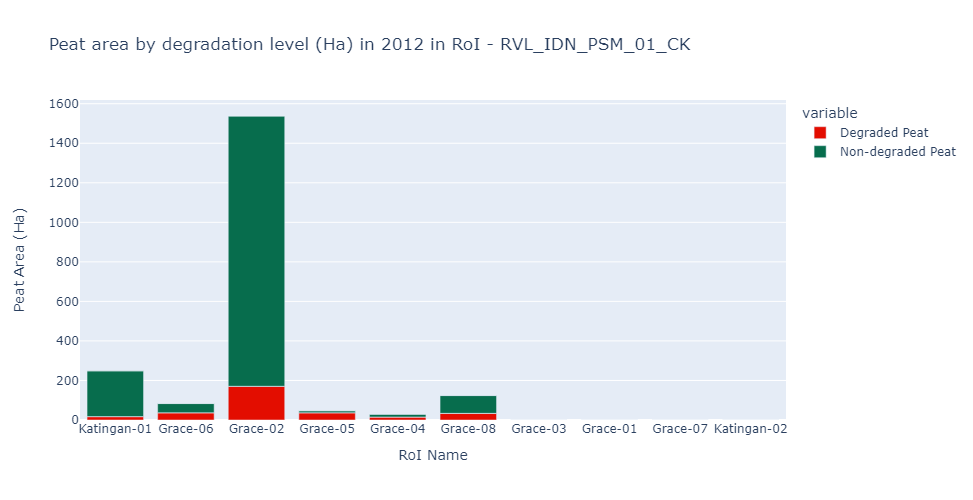

In [24]:
# Degraded Peat area in RoI
fig_degpeatarea_12 = px.bar(degradation_peatforestype_2012_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2012 in RoI - " + projectname)
fig_degpeatarea_12

#### Map - Degraded Peat in 2012

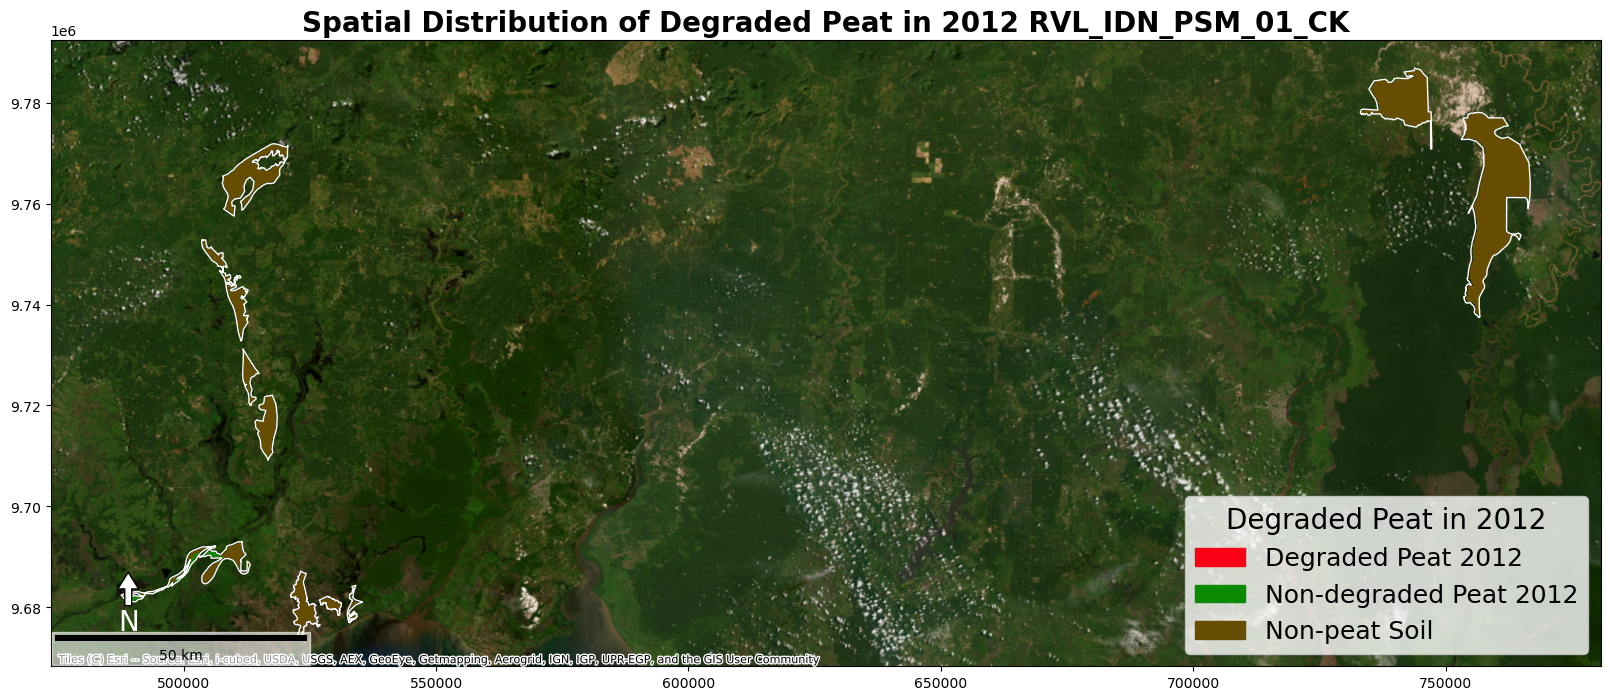

In [35]:
colors_degpeat12 = ['#fc0015','#0b8c00' ,'#674d01']
cmap_degpeat12 = ListedColormap(colors_degpeat12)
norm_degpeat_12 = colors.BoundaryNorm([0, 10.5, 11.5, 21], ncolors=3) #cmap_degpeat22.N, clip=False)

fig_degpeat12, ax_degpeat12 = plt.subplots(figsize=(20,20))

x, y, arrow_length = 0.05, 0.15, 0.08
ax_degpeat12.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length),
                      arrowprops=dict(facecolor='white', width=5, headwidth=15),
                      ha='center', va='center', fontsize=20,
                      xycoords=ax_degpeat12.transAxes)

ax_degpeat12.set_title(label='Degraded peat in 2012 - '+  projectname, fontsize=20, fontweight="bold")

legend_labels_degpeat12 = {"#fc0015": "Degraded Peat 2012",
                           "#0b8c00" : "Non-degraded Peat 2012",
                           "#674d01" : "Non-peat Soil"}
patches_degpeat12 = [Patch(color=color, label=label)
                     for color, label in legend_labels_degpeat12.items()]

legend_degpeat12 = ax_degpeat12.legend(handles=patches_degpeat12,facecolor="white", prop={'size': 18}, loc='lower right', title = "Degraded Peat in 2012")
plt.setp(legend_degpeat12.get_title(),fontsize='20')

ax_degpeat12.set_title('Spatial Distribution of Degraded Peat in 2012 ' + projectname, fontsize=20, fontweight="bold")

ax_degpeat12.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_degpeat12 = roi_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax_degpeat12)
ax_degpeat12 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_degpeat12 )
ax_degpeat12 = rasterio.plot.show(pnp_forest, ax=ax_degpeat12, cmap = cmap_degpeat12, norm = norm_degpeat_12)

### Degraded Peat in 2022

#### Area Estimation - Degraded Peat in 2022 

In [26]:
# Overlay forest by peat and non-peat
# peat * 10 + forest in 2012
#  10: non-forested peat -- degraded peat
#  11: forested peat
#  20: non-peat and non-forested -- nonpeat nonforested
#  21: nonpeat - forest --- non-peat forested area

upperleft_bound22 = forest22_geotiff.transform * (0, 0)
pixel_size22 = forest22_geotiff.transform[0]

forest_soiltype_overlay22 = peatnonpeat_raster.read(1) * 10 + forest22_geotiff.read(1)

new_transform22 = rasterio.transform.from_origin(upperleft_bound22[0],upperleft_bound22[1],pixel_size22,pixel_size22)

new_dataset_peat_forest22 = rasterio.open(
    os.path.join(raster_directory, projectname + '_degradedPeat_2022_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forest_soiltype_overlay22.shape[0],
    width = forest_soiltype_overlay22.shape[1],
    count = 1,
    nodata = 0,
    dtype = forest_soiltype_overlay22.dtype,
    crs = projection,
    transform = new_transform22
)
new_dataset_peat_forest22.write(forest_soiltype_overlay22, 1)
new_dataset_peat_forest22.close()

In [27]:
pnp_forest_2022 = rasterio.open(os.path.join(raster_directory, projectname + '_degradedPeat_2022_roi.tif').replace(os.sep, '/'))

In [28]:
# zonal histogram of peat + foresttype 2022
zs_soiltype_foresttype_22 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_degradedPeat_2022_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_22_df = pd.DataFrame(zs_soiltype_foresttype_22).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df * 30 *30 /10000
zs_soiltype_foresttype_22_df["total_area_ha"] = zs_soiltype_foresttype_22_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.rename({  10.0: 'Degraded Peat', 11.0: 'Non-degraded Peat',
                                                               20.0: 'Non-peat Non-Forest', 21.0: 'Non-peat Forest',}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.groupby(lambda x:x, axis=1).sum()

In [29]:
# join between degradation area table with roi_table
degradation_peatforestype_2022 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_22_df)
degradation_peatforestype_2022_df = pd.DataFrame(degradation_peatforestype_2022).fillna(0)
degradation_peatforestype_2022_df = degradation_peatforestype_2022_df.loc[(degradation_peatforestype_2022_df[[roi_column_name]] != 0).all(axis=1)]

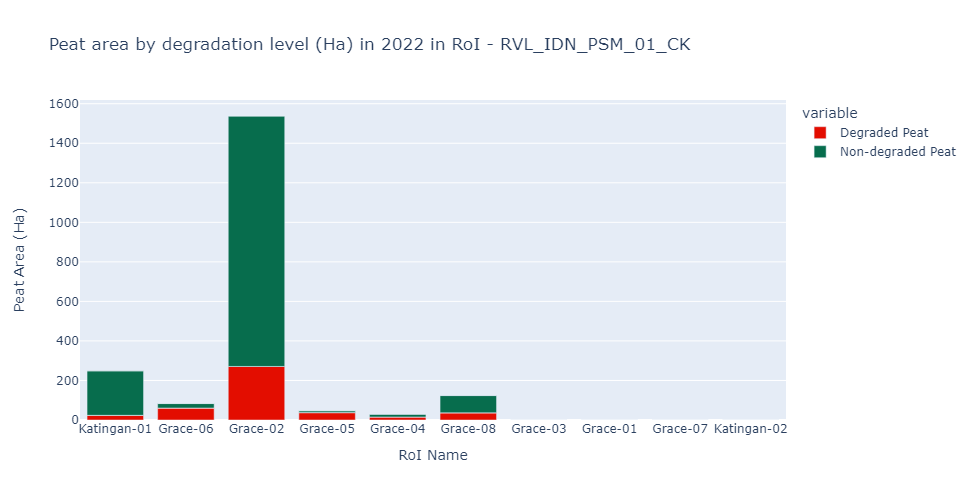

In [30]:
# Degraded Peat area in RoI
fig_degpeatarea_22 = px.bar(degradation_peatforestype_2022_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2022 in RoI - " + projectname)
fig_degpeatarea_22

#### Map - Degraded Peat in 2022

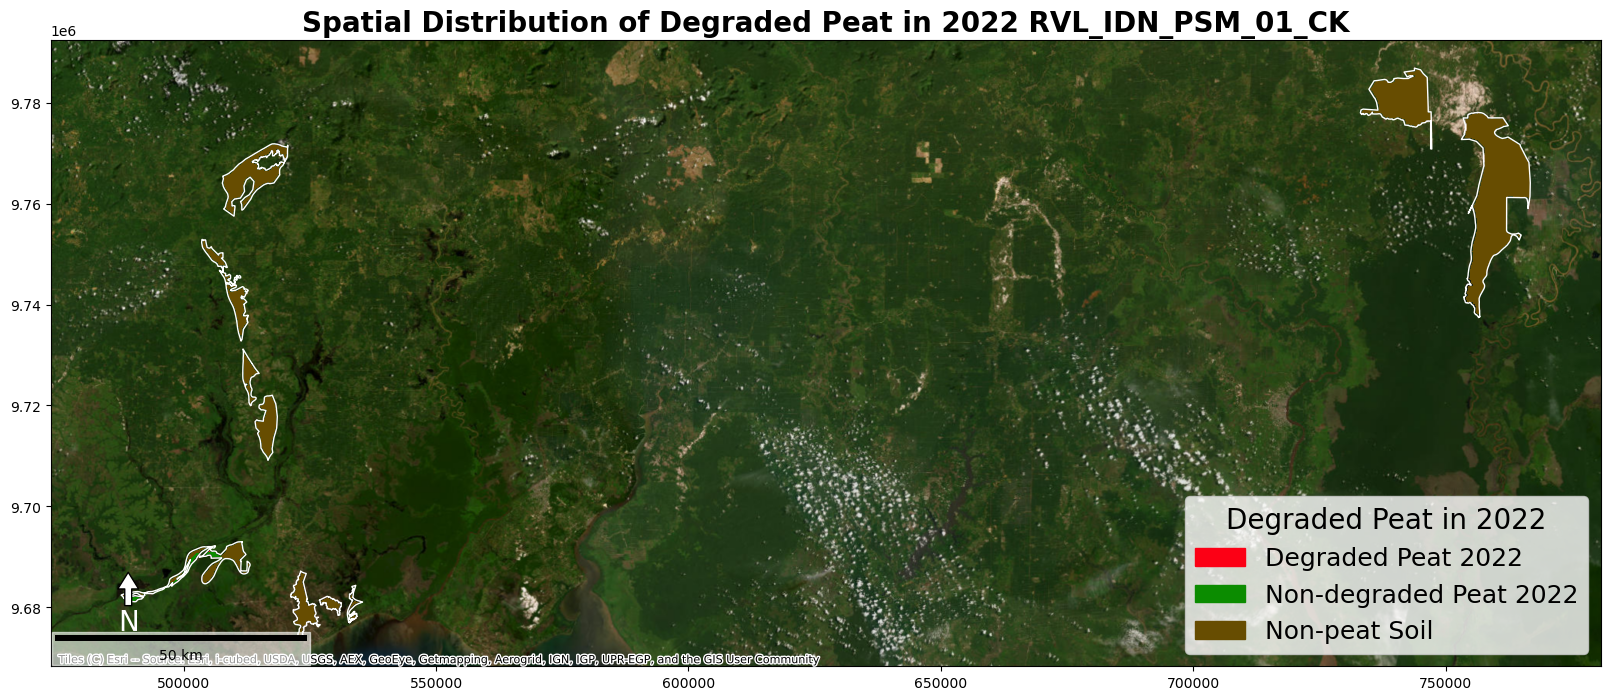

In [45]:
colors_degpeat22 = ['#fc0015','#0b8c00' ,'#674d01']
cmap_degpeat22 = ListedColormap(colors_degpeat22)
norm_degpeat = colors.BoundaryNorm([0, 10.5, 11.5, 21], ncolors=3) #cmap_degpeat22.N, clip=False)

fig_degpeat22, ax_degpeat22 = plt.subplots(figsize=(20,20))


x, y, arrow_length = 0.05, 0.15, 0.08
ax_degpeat22.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length),
                      arrowprops=dict(facecolor='white', width=5, headwidth=15),
                      ha='center', va='center', fontsize=20,
                      xycoords=ax_degpeat22.transAxes)

ax_degpeat22.set_title(label='Degraded peat in 2022 - '+  projectname, fontsize=20, fontweight="bold")

legend_labels_degpeat22 = {"#fc0015": "Degraded Peat 2022",
                           "#0b8c00": "Non-degraded Peat 2022",
                           "#674d01" : "Non-peat Soil"}
patches_degpeat22 = [Patch(color=color, label=label)
                     for color, label in legend_labels_degpeat22.items()]
legend_degpeat22 = ax_degpeat22.legend(handles=patches_degpeat22,facecolor="white", prop={'size': 18}, loc='lower right', title = "Degraded Peat in 2022")
plt.setp(legend_degpeat22.get_title(),fontsize='20')

ax_degpeat22.set_title('Spatial Distribution of Degraded Peat in 2022 ' + projectname, fontsize=20, fontweight="bold")

ax_degpeat22.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_degpeat22 = roi_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax_degpeat22)
ax_degpeat22 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_degpeat22 )
ax_degpeat22 = rasterio.plot.show(pnp_forest_2022, ax=ax_degpeat22, cmap = cmap_degpeat22, norm = norm_degpeat)

### Annual Forest Loss on Peat 2013-2021

In [39]:
# 1. overlay peat with forest loss
upperleft_bound3 = AnnualforestLoss_geotiff.transform * (0, 0)
pixel_size3 = AnnualforestLoss_geotiff.transform[0]

ForestLoss_2001_2021_overlay =  peatnonpeat_raster.read(1) * 100 + AnnualforestLoss_geotiff.read(1)

new_transform3 = rasterio.transform.from_origin(upperleft_bound3[0],upperleft_bound3[1],pixel_size3,pixel_size3)

new_dataset_ForestLoss = rasterio.open(
    os.path.join(raster_directory, projectname + '_PNP_ForestLoss_13_21_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = ForestLoss_2001_2021_overlay.shape[0],
    width = ForestLoss_2001_2021_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = ForestLoss_2001_2021_overlay.dtype,
    crs = projection,
    transform = new_transform3
)
new_dataset_ForestLoss.write(ForestLoss_2001_2021_overlay, 1)
new_dataset_ForestLoss.close()

In [40]:
ForestLoss_PNP_13_21 = rasterio.open(os.path.join(raster_directory, projectname + '_PNP_ForestLoss_13_21_roi.tif').replace(os.sep, '/'))

In [41]:
# 1. Annual Forest Loss - Zonal Statistic
za_ForestLoss_pnp_13_21 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_PNP_ForestLoss_13_21_roi.tif').replace(os.sep, '/'), categorical=True)
za_ForestLoss_pnp_13_21_df = pd.DataFrame(za_ForestLoss_pnp_13_21).fillna(0)
# Estimate Area from pixels count
za_ForestLoss_pnp_13_21_df = za_ForestLoss_pnp_13_21_df * 30 *30 /10000
za_ForestLoss_pnp_13_21_df["total_area_ha"] = za_ForestLoss_pnp_13_21_df.sum(axis=1)

# rename coloumn based on degradation category
za_ForestLoss_pnp_13_21_df = za_ForestLoss_pnp_13_21_df.rename({100.0: 'NonLoss', 101.0: 'Peat_FLoss1', 102.0 : 'Peat_FLoss2', 103.0 : 'Peat_FLoss3', 104.0 : 'Peat_FLoss4', 
                                                                    105.0: 'Peat_FLoss5', 106.0: 'Peat_FLoss6', 107.0 : 'Peat_FLoss7', 108.0 : 'Peat_FLoss8', 109.0 : 'Peat_FLoss9',
                                                                    110.0: 'Peat_FLoss10', 111.0: 'Peat_FLoss11', 112.0 : 'Peat_FLoss12', 113.0 : 'Peat_FLoss13', 114.0 : 'Peat_FLoss14',
                                                                    115.0: 'Peat_FLoss15', 116.0: 'Peat_FLoss16', 117.0 : 'Peat_FLoss17', 118.0 : 'Peat_FLoss18', 119.0 : 'Peat_FLoss19',
                                                                    120.0: 'Peat_FLoss20', 121.0: 'Peat_FLoss21',
                                                                    200.0: 'NonLoss', 201.0: 'NonPeat_FLoss1', 202.0 : 'NonPeat_FLoss2', 203.0 : 'NonPeat_FLoss3', 204.0 : 'NonPeat_FLoss4', 
                                                                    205.0: 'NonPeat_FLoss5', 206.0: 'NonPeat_FLoss6', 207.0 : 'NonPeat_FLoss7', 208.0 : 'NonPeat_FLoss8', 209.0 : 'NonPeat_FLoss9',
                                                                    210.0: 'NonPeat_FLoss10', 211.0: 'NonPeat_FLoss11', 212.0 : 'NonPeat_FLoss12', 213.0 : 'NonPeat_FLoss13', 214.0 : 'NonPeat_FLoss14',
                                                                    215.0: 'NonPeat_FLoss15', 216.0: 'NonPeat_FLoss16', 217.0 : 'NonPeat_FLoss17', 218.0 : 'NonPeat_FLoss18', 219.0 : 'NonPeat_FLoss19',
                                                                    220.0: 'NonPeat_FLoss20', 221.0: 'NonPeat_FLoss21',}, axis='columns')
# sum the duplicated columns
za_ForestLoss_pnp_13_21_df = za_ForestLoss_pnp_13_21_df.groupby(lambda x:x, axis=1).sum()

In [42]:
# join with roi
deforestation_peattype_2013_2021 = peat_nonpeat_roi_proj.join(za_ForestLoss_pnp_13_21_df)
deforestation_peattype_2001_2022_df = pd.DataFrame(deforestation_peattype_2013_2021).fillna(0)
deforestation_peattype_2001_2022_df = deforestation_peattype_2001_2022_df.loc[(deforestation_peattype_2001_2022_df[[roi_column_name]] != 0).all(axis=1)]
deforestation_peattype_2001_2022_df = deforestation_peattype_2001_2022_df.drop('geometry', axis =1 )

## Export Data

In [ ]:
# Export csv file
# 1. Degraded peat based on Forested area in 2012
degradation_peatforestype_2012_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2012.csv'))

# 2. Degraded peat based on Forested area in 2022
degradation_peatforestype_2022_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2022.csv'))

# 3. Deforestation on Peat
deforestation_peattype_2001_2022_df.to_csv(os.path.join(out_dir, projectname + '_RoI_ForestLoss_2001_2021.csv'))

In [ ]:
# # Export Graph
# # 1. Degraded peat in 2000/2001
# fig_degpeatarea_12.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2001_Graph.png'))
# # 2. Degraded peat in 2022
# fig_degpeatarea_22.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2022_Graph.png'))

In [43]:
# Export Map
# 1. Degraded Peat in 2000/2001
fig_degpeat12.savefig(os.path.join(out_dir, projectname + '_DegradedPeat_2012_Map.png'), facecolor='white',  bbox_inches='tight')
# 2. Degraded Peat in 2022
fig_degpeat22.savefig(os.path.join(out_dir, projectname + '_DegradedPeat_2022_Map.png'), facecolor='white',  bbox_inches='tight')

End script :)